<a href="https://colab.research.google.com/github/MauricioMatheus/Data_Structures_2_Final_Project/blob/main/Final_Project_pt_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [21]:
nodes_file = "1gzr_Nodes.txt"
edges_file = "1gzr_Edges.txt"

df_nodes = pd.read_csv(nodes_file, sep="\t")
df_edges = pd.read_csv(edges_file, sep="\t")

# Preview the node data
print("Nodes:")
display(df_nodes.head())  # Shows the first few rows of the node DataFrame

# Preview the edge data
print("Edges:")
display(df_edges.head())  # Shows the first few rows of the edge DataFrame

Nodes:


,NodeId,Chain,Position,Residue,Type,Dssp,Degree,Bfactor_CA,x,y,z,pdbFileName,Model
0,B:3:_:GLU,B,3,GLU,RES,,0,38.27,4.955,21.483,19.072,input_file.cif#3.B,1
1,B:4:_:THR,B,4,THR,RES,,1,30.53,7.423,19.262,20.919,input_file.cif#4.B,1
2,B:5:_:LEU,B,5,LEU,RES,,2,24.47,9.341,18.854,24.198,input_file.cif#5.B,1
3,B:6:_:CYS,B,6,CYS,RES,,4,22.13,13.116,19.083,24.529,input_file.cif#6.B,1
4,B:7:_:GLY,B,7,GLY,RES,H,1,24.99,15.854,19.690,27.032,input_file.cif#7.B,1


Edges:


,NodeId1,Interaction,NodeId2,Distance,Angle,Atom1,Atom2,Donor,Positive,Cation,Orientation,Model
0,B:4:_:THR,HBOND:SC_MC,B:47:_:CYS,2.490,112.205,OG1,O,B:4:_:THR,NaN,NaN,NaN,1
1,B:5:_:LEU,VDW:MC_SC,B:10:_:LEU,2.736,NaN,O,HB3,NaN,NaN,NaN,NaN,1
2,B:5:_:LEU,HBOND:MC_MC,B:47:_:CYS,2.930,162.028,N,O,B:5:_:LEU,NaN,NaN,NaN,1
3,B:6:_:CYS,HBOND:MC_MC,B:9:_:GLU,3.045,119.219,O,N,B:9:_:GLU,NaN,NaN,NaN,1
4,B:6:_:CYS,VDW:MC_SC,B:9:_:GLU,2.710,NaN,O,HB2,NaN,NaN,NaN,NaN,1


In [22]:
# Use MultiGraph() instead of MultiDiGraph() if directionality is not important.
# This allows multiple undirected edges between the same node pairs, useful for modeling
# symmetric or bidirectional interactions like Van der Waals forces.
G = nx.MultiGraph()

# Add all nodes with their attributes
for _, row in df_nodes.iterrows():
    node_id = row["NodeId"]                      # Extract the node identifier
    attributes = row.drop("NodeId").to_dict()    # Convert the remaining columns to a dictionary of attributes
    G.add_node(node_id, **attributes)            # Add the node and its attributes to the graph

print(f"Graph created with {G.number_of_nodes()} nodes.")


Graph created with 62 nodes.


In [23]:
# Adds all columns as edge attributes, allowing multiple edges between the same pair of nodes
for _, row in df_nodes.iterrows():
    G.add_node(row["NodeId"], **row.drop("NodeId").to_dict())
print(f"-> {G.number_of_nodes()} nós foram adicionados.")

# Adiciona arestas
for _, row in df_edges.iterrows():
    source = row["NodeId1"]
    target = row["NodeId2"]
    attributes = row.drop(["NodeId1", "NodeId2"]).to_dict()
    for key, val in attributes.items():
        try:
            attributes[key] = float(val)
        except (ValueError, TypeError):
            pass
    G.add_edge(source, target, **attributes)
print(f"-> {G.number_of_edges()} arestas foram adicionadas.")

-> 62 nós foram adicionados.
-> 81 arestas foram adicionadas.


In [24]:
print("Convertendo o Multigrafo para um Grafo simples para o cálculo do k-core...")
G_simple = nx.Graph(G)

print("Calculando a decomposição k-core no grafo simplificado...")
core_numbers = nx.core_number(G_simple)

nx.set_node_attributes(G, core_numbers, 'kcore')

print("Atributo 'kcore' adicionado com sucesso a todos os nós do grafo original.")


Convertendo o Multigrafo para um Grafo simples para o cálculo do k-core...
Calculando a decomposição k-core no grafo simplificado...
Atributo 'kcore' adicionado com sucesso a todos os nós do grafo original.


In [25]:
if core_numbers:
    print(f"---> Diagnóstico: K-Core Máximo encontrado: {max(core_numbers.values())}")


---> Diagnóstico: K-Core Máximo encontrado: 2


In [26]:
#Pegando o grau de cada nó no grafo simples
degrees = [val for (node, val) in G_simple.degree()]

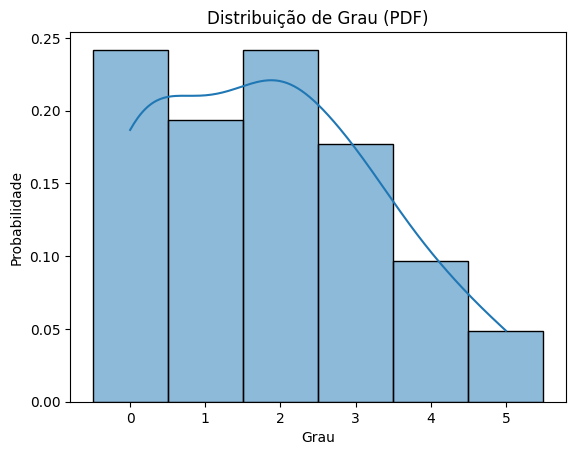

In [27]:
#Gerando o gráfico PDF (Probability Density Function)

sns.histplot(degrees, kde=True, stat='probability', discrete=True)
plt.title('Distribuição de Grau (PDF)')
plt.xlabel('Grau')
plt.ylabel('Probabilidade')
plt.show()

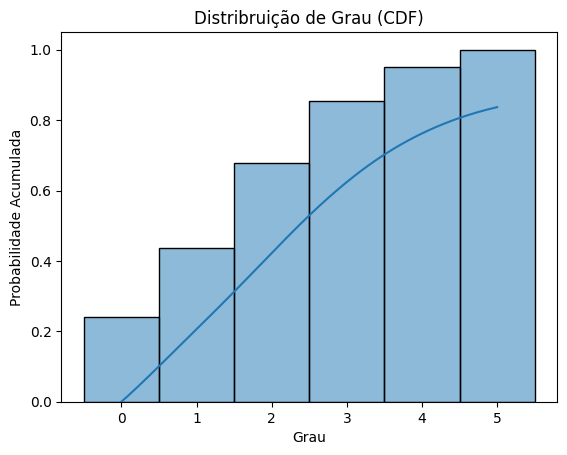

In [28]:
#Gerando o Gráfico CDF (Cumulative Density Function)

sns.histplot(degrees, kde=True, stat='probability', cumulative=True, discrete=True)
plt.title('Distribuição de Grau (CDF)')
plt.xlabel('Grau')
plt.ylabel('Probabilidade Acumulada')
plt.show()

In [29]:
#Calculando o valores de grau correspondentes a 25%, 50% (Mediana) e 75%
quartis = pd.Series(degrees).quantile([0.25, 0.5, 0.75])
print(quartis)

0.25    1.0
0.50    2.0
0.75    3.0
dtype: float64


In [32]:
#Calculando as centralidades para a análise multivariável das métricas

degree_centrality = nx.degree_centrality(G_simple)
betweenness_centrality = nx.betweenness_centrality(G_simple)
closeness_centrality = nx.closeness_centrality(G_simple)
eigenvector_centrality = nx.eigenvector_centrality(G_simple, max_iter=1000)

In [33]:
#Organizando em um DataFrame

df_centralities = pd.DataFrame({
    'Degree Centrality': degree_centrality,
    'Betweenness Centrality': betweenness_centrality,
    'Closeness Centrality': closeness_centrality,
    'Eigenvector Centrality': eigenvector_centrality
})

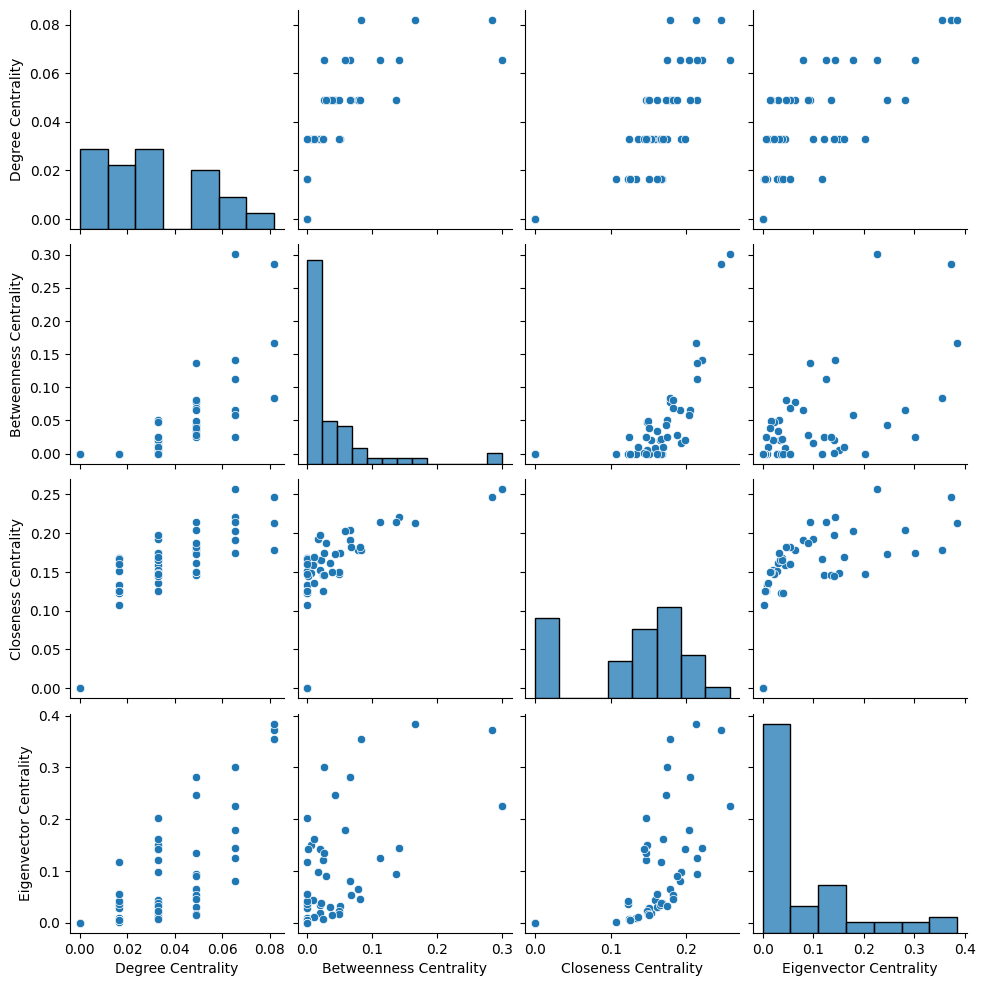

In [34]:
sns.pairplot(df_centralities)
plt.show()

In [35]:
#Periferia e Centro da Rede (Só funciona em grafos conectados)

giant_component_nodes = max(nx.connected_components(G_simple), key=len)
giant_graph = G_simple.subgraph(giant_component_nodes)
periphery = nx.periphery(giant_graph)
center = nx.center(giant_graph)

In [36]:
print(f"Periferia: {periphery}")
print(f"Centro: {center}")

Periferia: ['B:29:_:THR', 'B:49:_:PHE', 'B:50:_:ARG']
Centro: ['B:14:_:LEU']


In [30]:
#Exportação para manipulação no Gephi

def sanitize_attributes(G):
    # Fix node attributes: replace None or NaN values with empty strings
    for node, attrs in G.nodes(data=True):
        for k, v in attrs.items():
            if v is None or (isinstance(v, float) and pd.isna(v)):
                G.nodes[node][k] = ""

    # Fix edge attributes: replace None or NaN values with empty strings
    for u, v, key, attrs in G.edges(keys=True, data=True):
        for k, v_attr in attrs.items():
            if v_attr is None or (isinstance(v_attr, float) and pd.isna(v_attr)):
                G.edges[u, v, key][k] = ""

# Apply attribute sanitization to make the graph exportable to GEXF format
sanitize_attributes(G)

# Export the graph to a GEXF file, which can be opened in Gephi or reloaded in Python
nx.write_gexf(G, "final_netwokr.gexf")
print("Export completed successfully.")

Export completed successfully.


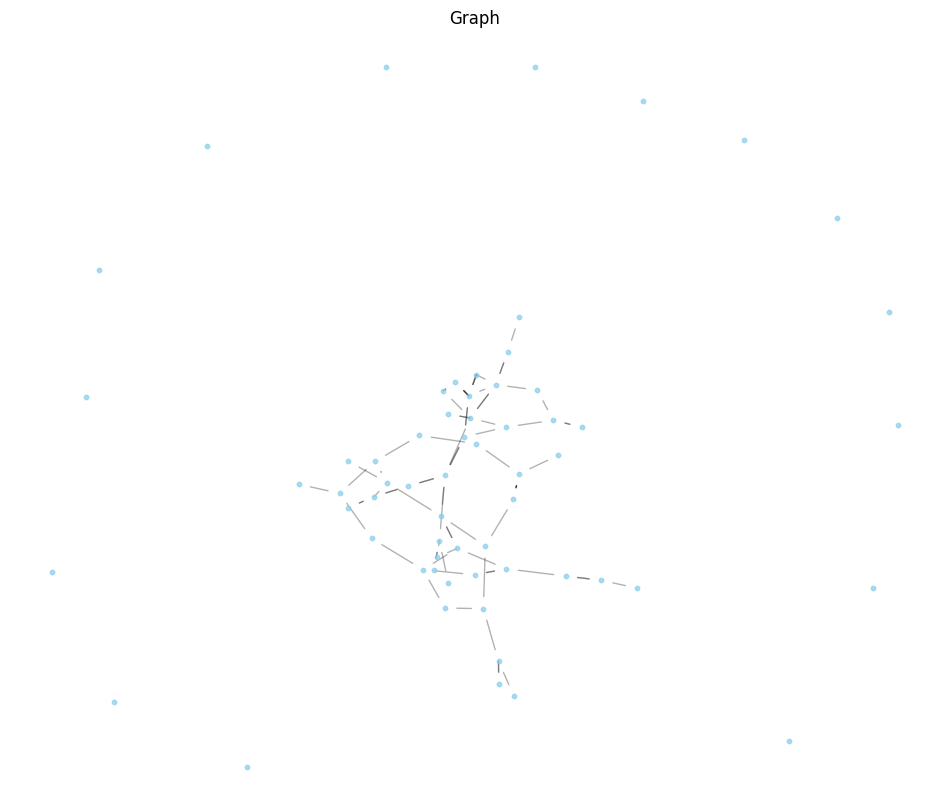

In [31]:
#Visualização rápida

# Generate a layout for positioning the nodes using a force-directed algorithm
# 'seed' ensures the layout is reproducible
pos = nx.spring_layout(G, seed=42)

# Set up the figure size
plt.figure(figsize=(12, 10))

# Draw the graph nodes with small size and light color
nx.draw_networkx_nodes(G, pos, node_size=10, node_color='skyblue', alpha=0.7)

# Draw the edges with some transparency
nx.draw_networkx_edges(G, pos, alpha=0.3)

# Set the plot title and remove axes
plt.title("Graph")
plt.axis('off')

# Display the final visualization
plt.show()
